## Final Group Assignment

### Group 4: Kumar Saurav Jha, Mahak Lakhani, Rei Osmani

### Please note that due to the large dataset and model traning, the code may take a significant time to run.

#### Intial Setup

In [1]:
# Import the necessary libraries

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from category_encoders import TargetEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import kagglehub

#### Loading Data
#### Kaggle - Blog Authorship Corpus - https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus
#### This dataset contains text from blogs written on or before 2004, with each blog being the work of a single user.

Content:
The Blog Authorship Corpus consists of the collected posts of 19,320 bloggers gathered from blogger.com in August 2004. The corpus incorporates a total of 681,288 posts and over 140 million words - or approximately 35 posts and 7250 words per person.

Each blog is presented as a separate file, the name of which indicates a blogger id# and the blogger’s self-provided gender, age, industry and astrological sign. (All are labeled for gender and age but for many, industry and/or sign is marked as unknown.)

In [2]:


# Download the dataset
path = kagglehub.dataset_download("rtatman/blog-authorship-corpus")

print("Path to dataset files:", path)

# Optional: If the dataset includes a CSV file, load it into pandas
import os
import pandas as pd

# Assuming there's a CSV file in the downloaded path
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_path = os.path.join(path, file)
        df = pd.read_csv(csv_path)
        print(f"Loaded dataset from {csv_path}")
        break

# Example usage of the DataFrame
print(df.head())

Path to dataset files: C:\Users\91914\.cache\kagglehub\datasets\rtatman\blog-authorship-corpus\versions\2
Loaded dataset from C:\Users\91914\.cache\kagglehub\datasets\rtatman\blog-authorship-corpus\versions\2\blogtext.csv
        id gender  age              topic      sign          date  \
0  2059027   male   15            Student       Leo   14,May,2004   
1  2059027   male   15            Student       Leo   13,May,2004   
2  2059027   male   15            Student       Leo   12,May,2004   
3  2059027   male   15            Student       Leo   12,May,2004   
4  3581210   male   33  InvestmentBanking  Aquarius  11,June,2004   

                                                text  
0             Info has been found (+/- 100 pages,...  
1             These are the team members:   Drewe...  
2             In het kader van kernfusie op aarde...  
3                   testing!!!  testing!!!            
4               Thanks to Yahoo!'s Toolbar I can ...  


If for some reason the above code doesn't work, simply go to "https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus", download the dataset and load using the next cell

In [ ]:
# df = pd.read_csv("blogtext.csv")

#### Age will be our target variable, so we will begin the preliminary exploration

In [45]:
# Age Distribution

df['age'].value_counts()

age
17    80859
24    80071
23    72889
16    72708
25    67051
26    55312
27    46124
15    41767
14    27400
34    21347
33    17584
35    17462
36    14229
13    13133
37     9317
38     7545
39     5556
40     5016
45     4482
43     4230
41     3738
48     3572
42     2908
46     2733
47     2207
44     2044
Name: count, dtype: int64

#### Data Cleaning

In [46]:
# Remove unnecessary characters (URLs, HTML tags, special characters) to prepare text for analysis.

# Clean the text data
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove non-alphanumeric characters and extra spaces
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [47]:
# Apply the clean_text function to the text column

df['clean_text'] = df['text'].apply(clean_text)
# Encode the gender column
label_encoder = LabelEncoder()
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])  # Male: 0, Female: 1

In [48]:
# Occupation Mapping

# Define the mapping
occupation_mapping = {
    # STEM
    'Technology': 'STEM', 'Engineering': 'STEM', 'Internet': 'STEM', 'Science': 'STEM',
    'Biotech': 'STEM', 'Telecommunications': 'STEM', 'Manufacturing': 'STEM', 
    'Chemicals': 'STEM', 'Architecture': 'STEM', 'Environment': 'STEM', 'Maritime': 'STEM',
    
    # Business, Finance, and Law
    'BusinessServices': 'Business-Finance-Law', 'Banking': 'Business-Finance-Law',
    'Accounting': 'Business-Finance-Law', 'InvestmentBanking': 'Business-Finance-Law',
    'RealEstate': 'Business-Finance-Law', 'Marketing': 'Business-Finance-Law', 
    'Advertising': 'Business-Finance-Law', 'Consulting': 'Business-Finance-Law',
    'Law': 'Business-Finance-Law', 'HumanResources': 'Business-Finance-Law',
    'Transportation': 'Business-Finance-Law',
    
    # Creative, Social, and Education
    'Arts': 'Creative-Social-Education', 'Education': 'Creative-Social-Education',
    'Religion': 'Creative-Social-Education', 'Communications-Media': 'Creative-Social-Education',
    'Publishing': 'Creative-Social-Education', 'Non-Profit': 'Creative-Social-Education',
    'Museums-Libraries': 'Creative-Social-Education', 'Fashion': 'Creative-Social-Education',
    'Sports-Recreation': 'Creative-Social-Education', 'Tourism': 'Creative-Social-Education',
    
    # Public Services and Miscellaneous
    'Government': 'Public-Services-Misc', 'Military': 'Public-Services-Misc',
    'LawEnforcement-Security': 'Public-Services-Misc', 'Construction': 'Public-Services-Misc',
    'Agriculture': 'Public-Services-Misc', 'Automotive': 'Public-Services-Misc',
    'Maritime': 'Public-Services-Misc', 'indUnk': 'Public-Services-Misc', 'Student': 'Public-Services-Misc'
}

# Apply the mapping
df['occupation_grouped'] = df['topic'].map(occupation_mapping)

# Check distribution
print(df['occupation_grouped'].value_counts())

occupation_grouped
Public-Services-Misc         420683
Creative-Social-Education    122837
STEM                          91538
Business-Finance-Law          46226
Name: count, dtype: int64


We can see from the grouped occupations that our data is fairly imbalanced in this regard. The majority is found in the Public Services and Creative-Social-Education.

In [49]:
# %%

# Define age groups
bins = [0, 17, 29, float('inf')]  # Adjust the ranges as per chosen grouping
labels = ['Adolescents', 'Young Adults', 'Adults']

# Create a new categorical column
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# Check distribution
print(df['age_group'].value_counts())

age_group
Young Adults    321447
Adolescents     235867
Adults          123970
Name: count, dtype: int64


Unlike, the occupation group, the age group is fairly balanced and will serve as an appropriate target variable

In [50]:
# %%

# Encode the gender column
label_encoder = LabelEncoder()
df['gender_encoded'] = label_encoder.fit_transform(df['gender'])  # Male: 0, Female: 1

In [51]:
# %%

# Encode the age_group column
label_encoder = LabelEncoder()
df['age_encoded'] = label_encoder.fit_transform(df['age_group'])

#### Data Cleaning

In [ ]:
# Data Summary

print(df.shape)
print(df.info())
print(df.isnull().sum())
print(df.describe())

(681284, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  681284 non-null  int64   
 1   gender              681284 non-null  object  
 2   age                 681284 non-null  int64   
 3   topic               681284 non-null  object  
 4   sign                681284 non-null  object  
 5   date                681284 non-null  object  
 6   text                681284 non-null  object  
 7   clean_text          681284 non-null  object  
 8   gender_encoded      681284 non-null  int64   
 9   occupation_grouped  681284 non-null  object  
 10  age_group           681284 non-null  category
 11  age_encoded         681284 non-null  int64   
dtypes: category(1), int64(4), object(7)
memory usage: 57.8+ MB
None
id                    0
gender                0
age                   0
topic                

<Axes: title={'center': 'Age Group Distribution'}, xlabel='age_group'>

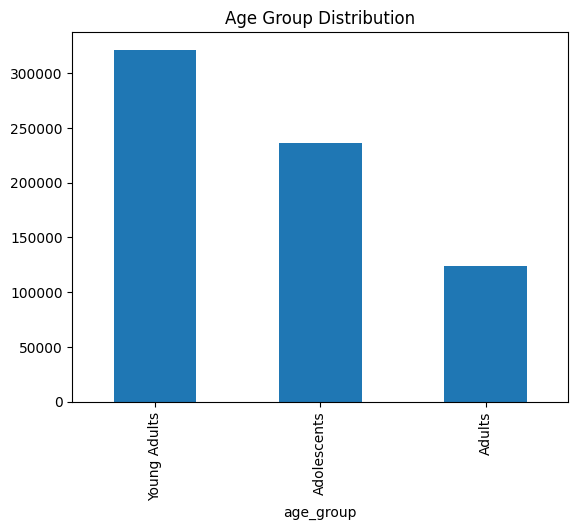

In [ ]:
# Target Varibale Analysis

df['age_group'].value_counts().plot(kind='bar', title='Age Group Distribution')

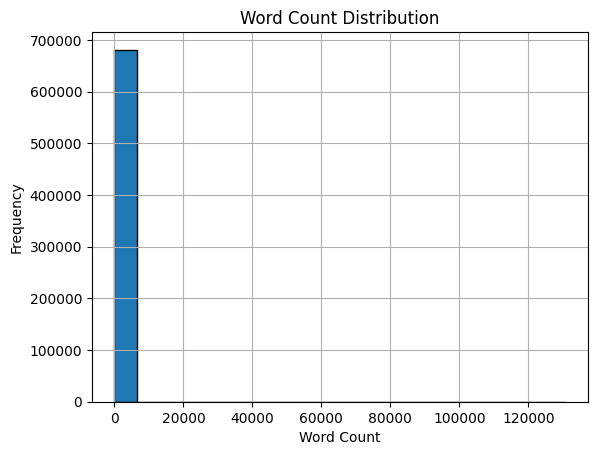

In [ ]:
# Word Count Distribution

import matplotlib.pyplot as plt

# Word Count Analysis
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Plot histogram
df['word_count'].hist(bins=20, edgecolor='k')
plt.title('Word Count Distribution')  # Add title using Matplotlib
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

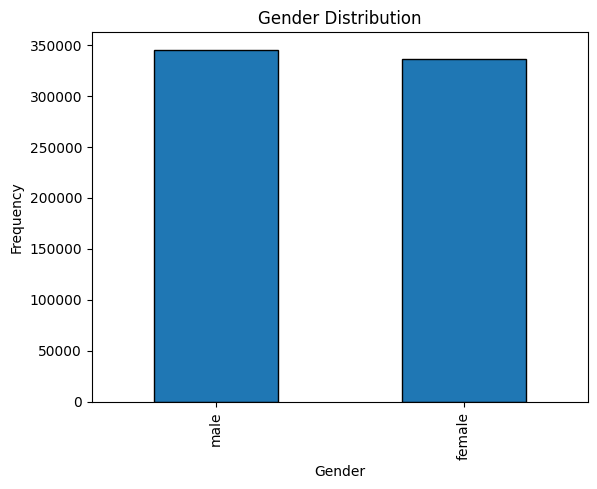

In [ ]:
# Plot gender distribution
df['gender'].value_counts().plot(kind='bar', title='Gender Distribution', edgecolor='k')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.show()

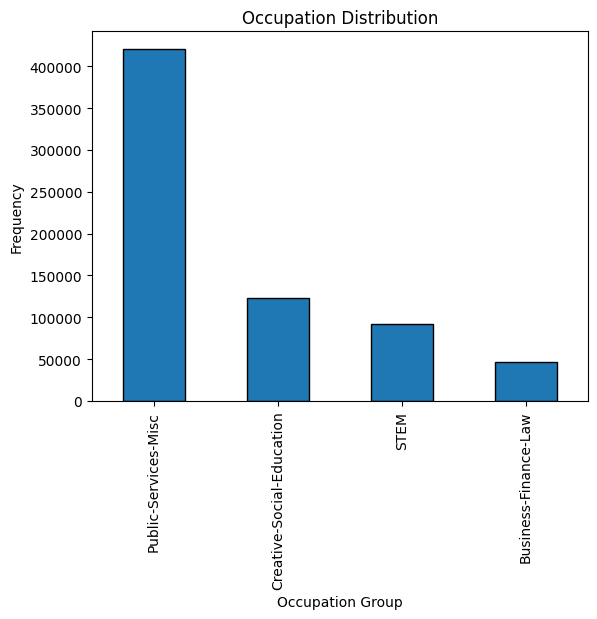

In [ ]:
# Plot occupation group distribution
df['occupation_grouped'].value_counts().plot(kind='bar', title='Occupation Distribution', edgecolor='k')
plt.xlabel('Occupation Group')
plt.ylabel('Frequency')
plt.show()

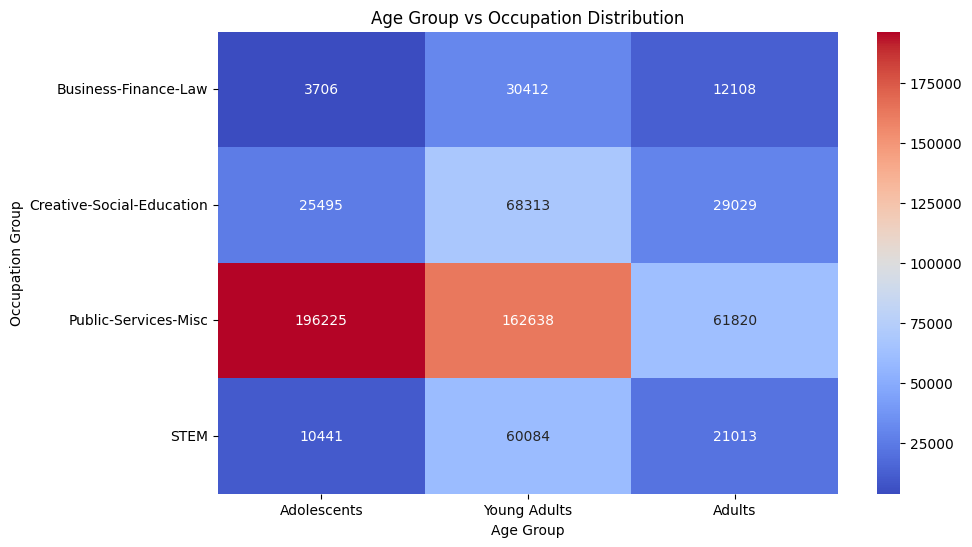

In [ ]:
import seaborn as sns

# Create a pivot table for the count of age groups in each occupation group
age_occ_pivot = df.pivot_table(index='occupation_grouped', columns='age_group', values='clean_text', aggfunc='count')

# Visualize the relationship
plt.figure(figsize=(10, 6))
sns.heatmap(age_occ_pivot, annot=True, fmt='.0f', cmap='coolwarm')
plt.title('Age Group vs Occupation Distribution')
plt.xlabel('Age Group')
plt.ylabel('Occupation Group')
plt.show()

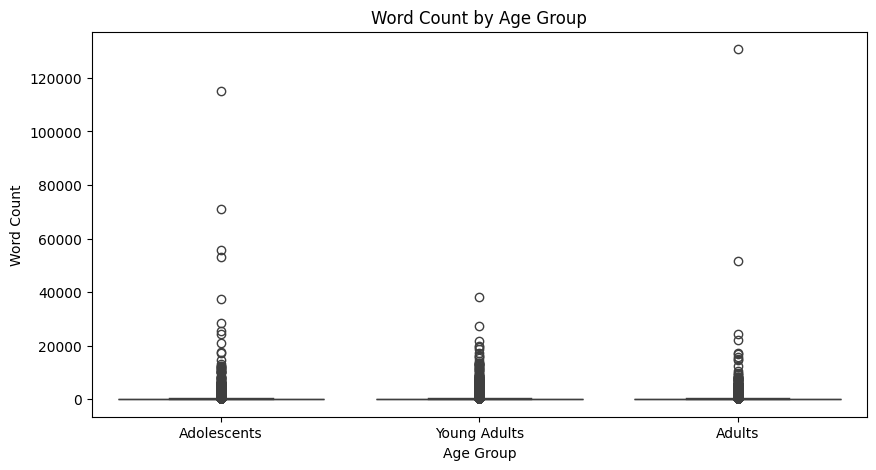

In [ ]:
# Boxplot of word count by age group
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='age_group', y='word_count')
plt.title('Word Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Word Count')
plt.show()

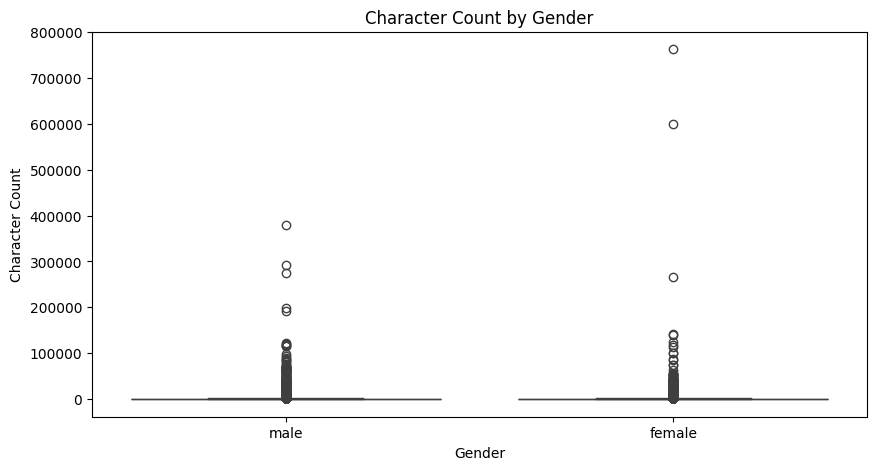

In [ ]:
# Boxplot of character count by gender
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='gender', y='char_count')
plt.title('Character Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Character Count')
plt.show()

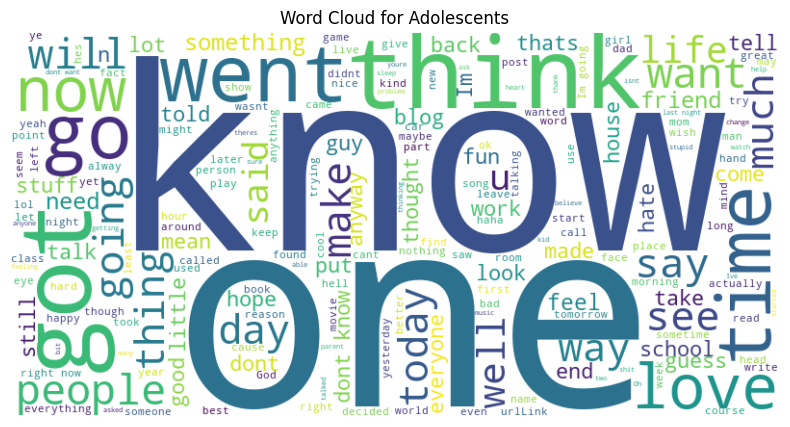

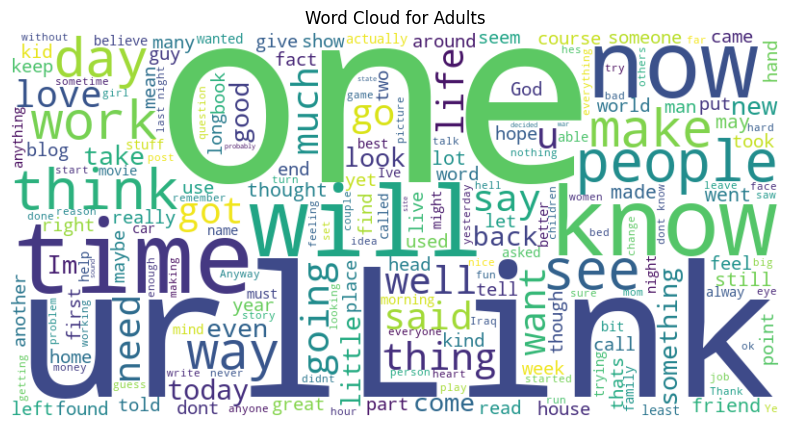

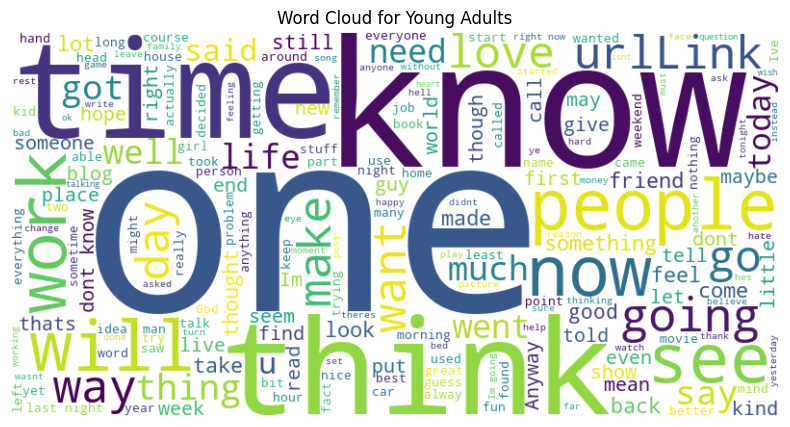

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate and display word clouds for each age group
age_groups = df['age_group'].unique()

for group in age_groups:
    group_text = ' '.join(df[df['age_group'] == group]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(group_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {group}')
    plt.show()

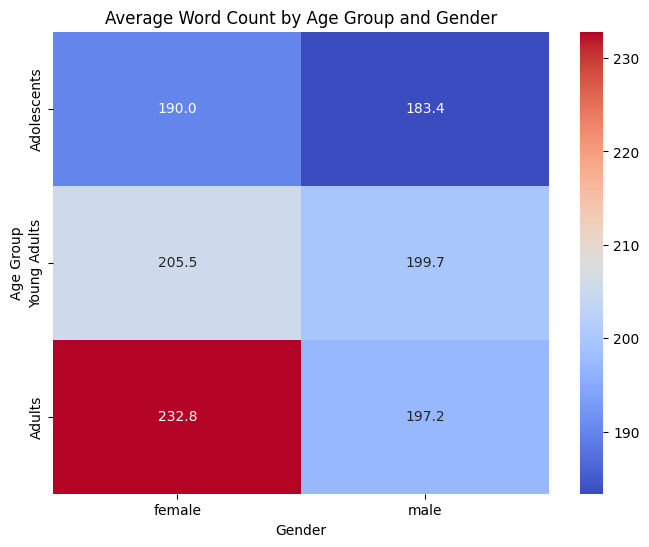

In [ ]:
# Pivot table for average word count by age group and gender
pivot_table = df.pivot_table(values='word_count', index='age_group', columns='gender', aggfunc='mean')

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Average Word Count by Age Group and Gender')
plt.xlabel('Gender')
plt.ylabel('Age Group')
plt.show()

/var/folders/j6/gl41x91d7hn2_977tdfz8tk80000gn/T/ipykernel_50056/284995275.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df, x='occupation_grouped', y='char_count', palette='viridis')


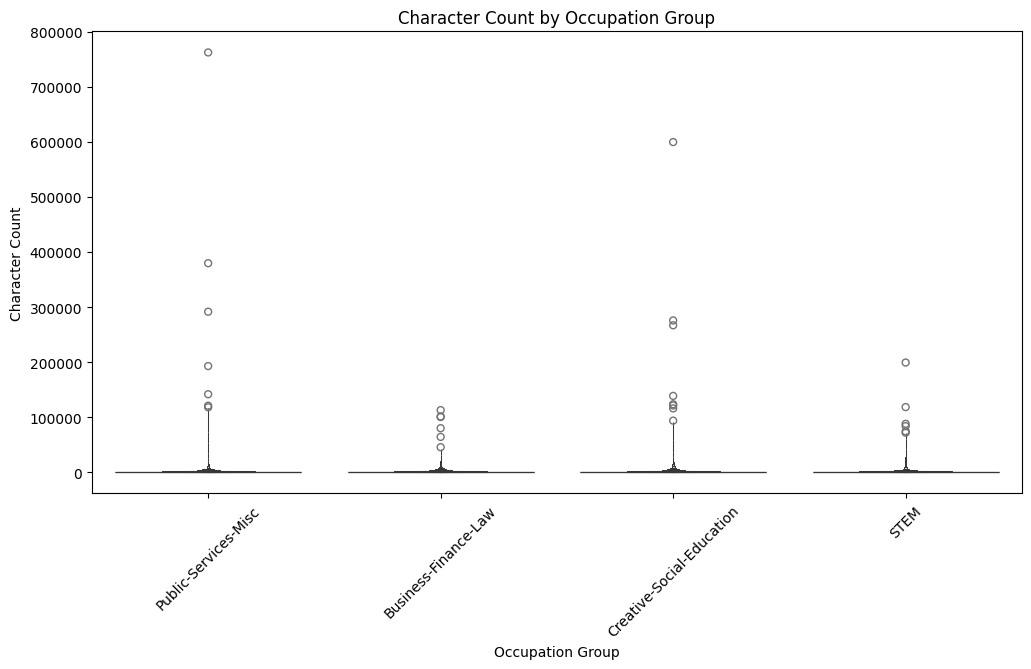

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxenplot(data=df, x='occupation_grouped', y='char_count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Character Count by Occupation Group')
plt.xlabel('Occupation Group')
plt.ylabel('Character Count')
plt.show()

/var/folders/j6/gl41x91d7hn2_977tdfz8tk80000gn/T/ipykernel_50056/1419146184.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(['age_group', 'gender'])['word_count'].mean().unstack()


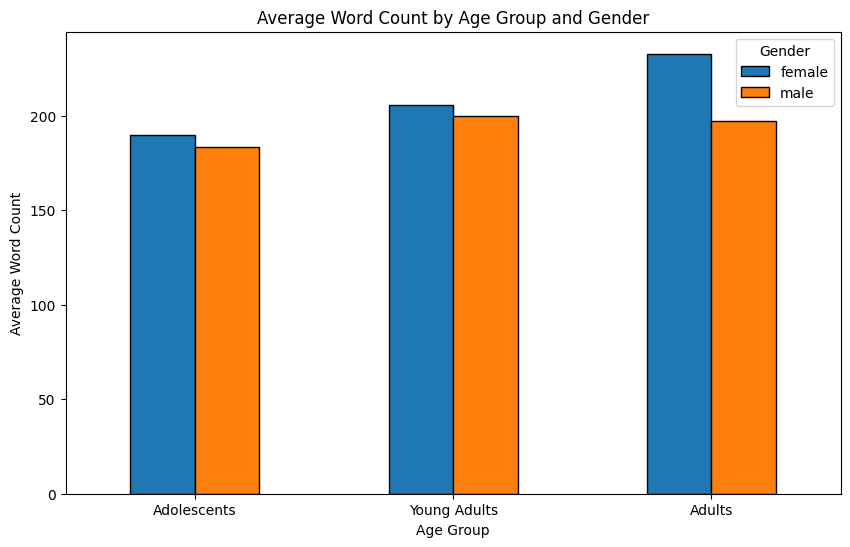

In [ ]:
# Grouped bar plot for word count
grouped_data = df.groupby(['age_group', 'gender'])['word_count'].mean().unstack()

grouped_data.plot(kind='bar', figsize=(10, 6), edgecolor='k')
plt.title('Average Word Count by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Average Word Count')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.show()

#### Model Preparation

In [ ]:
# %%

# Split your data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    df[['clean_text','gender_encoded','occupation_grouped']],  # Replace 'other_features' with your actual columns
    df['age_encoded'],
    test_size=0.2,
    random_state=42
)

In [ ]:
#%%

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 545027
Test set size: 136257


In [ ]:
# %%

# Initialize the Target Encoder
encoder = TargetEncoder(cols=['occupation_grouped'])

# Fit the encoder on the training data and transform
X_train['occupation_encoded'] = encoder.fit_transform(X_train['occupation_grouped'], y_train)

# Apply the same transformation to the test data
X_test['occupation_encoded'] = encoder.transform(X_test['occupation_grouped'])

# Check results
print(X_train[['occupation_grouped', 'occupation_encoded']].head())

               occupation_grouped  occupation_encoded
278509  Creative-Social-Education            1.349294
572041       Public-Services-Misc            0.919386
146044       Public-Services-Misc            0.919386
569591       Public-Services-Misc            0.919386
580033                       STEM            1.543025


#### Model Training

In [ ]:
#%%

X_train.drop(columns=['occupation_grouped'], inplace=True)

In [ ]:
#%%

X_test.drop(columns=['occupation_grouped'], inplace=True)

In [ ]:
#%%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### **Using Contextual Embeddings**

- **DistilBERT Tokenizer and Model**: 
  - Loaded from Hugging Face's `transformers` library.
  - `DistilBertTokenizer` is used for tokenizing text into input IDs and attention masks.
  - `DistilBertModel` generates **contextual embeddings** (768-dimensional vectors) for each sentence.
- **Device Utilization**: 
  - The model is moved to the appropriate device (`CPU` or `GPU`) for efficient computation.
- **Evaluation Mode**: 
  - The model is set to `eval` mode to disable gradients during embedding generation.

In [ ]:
# %%

'''using Contextual embeddings'''

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
model = model.to(device)
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
#%%

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

### **Embedding Generation Function**

This function generates **contextual embeddings** for a given list of texts using DistilBERT.

#### **Key Steps**:
1. **Batch Processing**:
   - Texts are processed in batches (default batch size: 32) for efficient computation.
   - Each batch is tokenized into input IDs and attention masks using the DistilBERT tokenizer.

2. **Tokenization**:
   - Texts are padded to a maximum length of 128 tokens.
   - Truncation is applied to longer texts to maintain uniform input dimensions.

3. **Model Inference**:
   - The tokenized inputs are passed through the pre-trained DistilBERT model in evaluation mode (`torch.no_grad()`).
   - The model outputs token-level embeddings (`last_hidden_state`).

4. **Sentence Embedding**:
   - **Mean pooling** is applied over all token embeddings to compute a single 768-dimensional vector for each text.

5. **Output**:
   - All sentence embeddings are concatenated into a single tensor of shape `(num_samples, 768)`.

#### **Usage**:
- Call this function with:
  - A list of texts.
  - Pre-loaded DistilBERT tokenizer and model.
  - Additional parameters such as `max_length` and `batch_size` for flexibility.

In [ ]:
# %%

def generate_embeddings(texts, tokenizer, model, max_length=128, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating Embeddings"):
        # Tokenize text
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(
            batch_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        # print(tokens)
        input_ids = tokens['input_ids'].to(device)
        # print(input_ids)
        attention_mask = tokens['attention_mask'].to(device)
        # print(attention_mask)

        # Pass through model
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # print(outputs)
            token_embeddings = outputs.last_hidden_state  # Shape: [batch_size, sequence_length, hidden_size]
            sentence_embedding = torch.mean(token_embeddings, dim=1)  # Mean pooling over tokens
            # print(sentence_embedding)
            embeddings.append(sentence_embedding)
    
    return torch.cat(embeddings, dim=0)  # Return as a single tensor

In [ ]:
#%%

# Generate embeddings for training and testing datasets
X_train_embeddings = generate_embeddings(X_train['clean_text'].tolist(), tokenizer, model)

Generating Embeddings: 100%|██████████| 17033/17033 [28:43<00:00,  9.88it/s]


In [ ]:
#%%

occupation_train_tensor = torch.tensor(X_train['occupation_encoded'].values, dtype=torch.float32).unsqueeze(1).to(device)
gender_train_tensor = torch.tensor(X_train['gender_encoded'].values, dtype=torch.float32).unsqueeze(1).to(device)
X_train_combined = torch.cat([X_train_embeddings, occupation_train_tensor, gender_train_tensor], dim=1)

print(f"Combined Train Features Shape: {X_train_combined.shape}")

Combined Train Features Shape: torch.Size([545027, 770])


In [ ]:
#%%

X_test_embeddings = generate_embeddings(X_test['clean_text'].tolist(), tokenizer, model)

Generating Embeddings: 100%|██████████| 4259/4259 [07:08<00:00,  9.95it/s]


### **Combining Features**

This block combines contextual sentence embeddings with additional encoded features to create a unified input for the model.

#### **Key Steps**:
1. **Feature Conversion**:
   - **`occupation_encoded`** and **`gender_encoded`** columns from `X_train` are converted into PyTorch tensors.
   - `unsqueeze(1)` ensures the tensors have the correct shape for concatenation (adding a dimension).

2. **Feature Combination**:
   - **`X_train_embeddings`** (768-dimensional vectors from DistilBERT) are concatenated with:
     - `occupation_train_tensor` (1 dimension).
     - `gender_train_tensor` (1 dimension).
   - The resulting tensor has a combined shape of `(num_samples, 770)`.

3. **Device Placement**:
   - All tensors are moved to the same device (CPU or GPU) to avoid runtime errors during concatenation.

#### **Output**:
- A unified tensor, **`X_train_combined`**, ready for input into the model.

#### **Purpose**:
- Integrates **contextual embeddings** with additional categorical features for improved model performance.

In [ ]:
#%%

occupation_test_tensor = torch.tensor(X_test['occupation_encoded'].values, dtype=torch.float32).unsqueeze(1).to(device)
gender_test_tensor = torch.tensor(X_test['gender_encoded'].values, dtype=torch.float32).unsqueeze(1).to(device)
X_test_combined = torch.cat([X_test_embeddings, occupation_test_tensor, gender_test_tensor], dim=1)

print(f"Combined Test Features Shape: {X_test_combined.shape}")

Combined Test Features Shape: torch.Size([136257, 770])


In [ ]:
# %%

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

<ipython-input-27-c0daa6752426>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
<ipython-input-27-c0daa6752426>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).to(device)


### **Defining the Model**

This block defines the **`AgeGroupPredictor`**, a fully connected feedforward neural network designed for multi-class classification.

#### **Model Architecture**:
1. **Input Layer**:
   - Takes a feature vector of size `input_dim` (e.g., 770: 768 from DistilBERT, 1 for gender, 1 for occupation).

2. **Hidden Layers**:
   - **Layer 1**: Fully connected layer with 256 neurons.
   - **Layer 2**: Fully connected layer with 128 neurons.
   - **Layer 3**: Fully connected layer with 64 neurons.
   - **Layer 4**: Fully connected layer with 32 neurons.
   - Each layer is followed by:
     - **ReLU activation**: Adds non-linearity to the model.
     - **Dropout (0.3)**: Prevents overfitting by randomly deactivating neurons during training.

3. **Output Layer**:
   - Fully connected layer with `num_classes` neurons (one for each class).
   - Outputs raw logits suitable for use with **CrossEntropyLoss**.

#### **Forward Pass**:
- Sequentially applies:
  - Linear transformations.
  - Non-linear activations (ReLU).
  - Dropout regularization (on the first two layers).
- Returns logits, which represent unnormalized scores for each class.

#### **Purpose**:
- Maps the combined input features (`X_train_combined`) to the corresponding age group classes.

#### **Key Features**:
- **ReLU Activation**: Introduces non-linearity.
- **Dropout Regularization**: Reduces overfitting during training.
- **Modular Design**: Easy to extend or modify by adjusting layer sizes or adding layers.

In [ ]:
# %%

# Define the model
class AgeGroupPredictor(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(AgeGroupPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
# %%

# Initialize model
input_dim = X_train_combined.shape[1]
num_classes = len(y_train.unique())  # Number of classes
model = AgeGroupPredictor(input_dim, num_classes).to(device)

### **Defining the Loss Function and Optimizer**

#### **1. Loss Function**
- **`nn.CrossEntropyLoss()`**:
  - A standard loss function for multi-class classification.
  - Computes the loss between raw logits (output of the model) and target class indices.
  - Handles multiple classes (e.g., predicting age groups) efficiently.

#### **2. Optimizer**
- **`optim.Adam`**:
  - Adaptive Gradient Optimization algorithm.
  - Combines the advantages of RMSProp and SGD with momentum.
  - **Learning Rate**: Set to `0.001` for balanced convergence and stability.

#### **Purpose**:
- **Loss Function**: Guides the model's learning by penalizing incorrect predictions.
- **Optimizer**: Updates model weights to minimize the loss function during training. 

These choices ensure efficient and effective training of the model.

In [ ]:
# %%

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

### **Training and Evaluation Loop**

#### **Training Phase**:
- **Epochs**: Trains the model for 50 iterations over the dataset.
- **Batch Processing**:
  - Data is split into batches of size 32.
  - For each batch:
    - Forward pass: Computes predictions.
    - Backward pass: Updates weights to minimize the loss using the optimizer.
- **Metrics**:
  - Tracks training loss and accuracy for each epoch.

#### **Evaluation Phase**:
- The model is set to evaluation mode (`model.eval()`).
- Predictions are computed on the test set.
- Outputs metrics:
  - **Test Accuracy**.
  - **Classification Report** (precision, recall, F1-score for each class). 

This loop ensures the model is trained efficiently and evaluated comprehensively.

In [ ]:
# %%

# Training loop
epochs = 50
batch_size = 32
model.train()

for epoch in range(epochs):
    epoch_loss = 0
    correct=0
    total = 0
    print(f"Epoch {epoch+1}/{epochs}")
    for i in tqdm(range(0, len(X_train_tensor), batch_size), desc="Training Batches"):
        # Batch data
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        epoch_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    # Calculate metrics
    avg_loss = epoch_loss / (len(X_train_tensor) // batch_size)
    accuracy = correct / total * 100
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    y_pred = torch.argmax(outputs, dim=1)

print(f"Test Accuracy: {accuracy_score(y_test_tensor.cpu(), y_pred.cpu()):.4f}")
print("\nClassification Report:")    
print(classification_report(y_test_tensor.cpu(), y_pred.cpu()))

Epoch 1/50


Training Batches: 100%|██████████| 17033/17033 [00:37<00:00, 452.15it/s]


Epoch [1/50], Loss: 0.8209, Accuracy: 61.95%
Epoch 2/50


Training Batches: 100%|██████████| 17033/17033 [00:35<00:00, 477.55it/s]


Epoch [2/50], Loss: 0.7944, Accuracy: 63.32%
Epoch 3/50


Training Batches: 100%|██████████| 17033/17033 [00:35<00:00, 476.49it/s]


Epoch [3/50], Loss: 0.7857, Accuracy: 63.81%
Epoch 4/50


Training Batches: 100%|██████████| 17033/17033 [00:35<00:00, 475.01it/s]


Epoch [4/50], Loss: 0.7789, Accuracy: 64.20%
Epoch 5/50


Training Batches: 100%|██████████| 17033/17033 [00:35<00:00, 474.07it/s]


Epoch [5/50], Loss: 0.7745, Accuracy: 64.47%
Epoch 6/50


Training Batches: 100%|██████████| 17033/17033 [00:35<00:00, 475.81it/s]


Epoch [6/50], Loss: 0.7699, Accuracy: 64.77%
Epoch 7/50


Training Batches: 100%|██████████| 17033/17033 [00:35<00:00, 476.53it/s]


Epoch [7/50], Loss: 0.7668, Accuracy: 64.90%
Epoch 8/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 471.04it/s]


Epoch [8/50], Loss: 0.7637, Accuracy: 65.05%
Epoch 9/50


Training Batches: 100%|██████████| 17033/17033 [00:35<00:00, 475.03it/s]


Epoch [9/50], Loss: 0.7617, Accuracy: 65.15%
Epoch 10/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 468.22it/s]


Epoch [10/50], Loss: 0.7596, Accuracy: 65.32%
Epoch 11/50


Training Batches: 100%|██████████| 17033/17033 [00:37<00:00, 459.42it/s]


Epoch [11/50], Loss: 0.7571, Accuracy: 65.40%
Epoch 12/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 462.61it/s]


Epoch [12/50], Loss: 0.7552, Accuracy: 65.55%
Epoch 13/50


Training Batches: 100%|██████████| 17033/17033 [00:37<00:00, 458.74it/s]


Epoch [13/50], Loss: 0.7532, Accuracy: 65.54%
Epoch 14/50


Training Batches: 100%|██████████| 17033/17033 [00:37<00:00, 460.35it/s]


Epoch [14/50], Loss: 0.7514, Accuracy: 65.76%
Epoch 15/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 461.16it/s]


Epoch [15/50], Loss: 0.7498, Accuracy: 65.76%
Epoch 16/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 461.37it/s]


Epoch [16/50], Loss: 0.7483, Accuracy: 65.92%
Epoch 17/50


Training Batches: 100%|██████████| 17033/17033 [00:37<00:00, 458.78it/s]


Epoch [17/50], Loss: 0.7468, Accuracy: 65.94%
Epoch 18/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 463.04it/s]


Epoch [18/50], Loss: 0.7457, Accuracy: 66.05%
Epoch 19/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 462.34it/s]


Epoch [19/50], Loss: 0.7435, Accuracy: 66.17%
Epoch 20/50


Training Batches: 100%|██████████| 17033/17033 [00:37<00:00, 460.16it/s]


Epoch [20/50], Loss: 0.7425, Accuracy: 66.25%
Epoch 21/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 466.12it/s]


Epoch [21/50], Loss: 0.7418, Accuracy: 66.30%
Epoch 22/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 466.77it/s]


Epoch [22/50], Loss: 0.7406, Accuracy: 66.34%
Epoch 23/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 462.40it/s]


Epoch [23/50], Loss: 0.7396, Accuracy: 66.38%
Epoch 24/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 465.01it/s]


Epoch [24/50], Loss: 0.7379, Accuracy: 66.45%
Epoch 25/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 471.27it/s]


Epoch [25/50], Loss: 0.7369, Accuracy: 66.55%
Epoch 26/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 469.46it/s]


Epoch [26/50], Loss: 0.7364, Accuracy: 66.54%
Epoch 27/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 472.48it/s]


Epoch [27/50], Loss: 0.7352, Accuracy: 66.57%
Epoch 28/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 472.07it/s]


Epoch [28/50], Loss: 0.7341, Accuracy: 66.66%
Epoch 29/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 469.93it/s]


Epoch [29/50], Loss: 0.7332, Accuracy: 66.73%
Epoch 30/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 473.05it/s]


Epoch [30/50], Loss: 0.7330, Accuracy: 66.72%
Epoch 31/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 464.56it/s]


Epoch [31/50], Loss: 0.7322, Accuracy: 66.78%
Epoch 32/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 464.51it/s]


Epoch [32/50], Loss: 0.7306, Accuracy: 66.85%
Epoch 33/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 465.79it/s]


Epoch [33/50], Loss: 0.7302, Accuracy: 66.85%
Epoch 34/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 465.02it/s]


Epoch [34/50], Loss: 0.7298, Accuracy: 66.88%
Epoch 35/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 464.78it/s]


Epoch [35/50], Loss: 0.7289, Accuracy: 66.95%
Epoch 36/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 462.86it/s]


Epoch [36/50], Loss: 0.7282, Accuracy: 66.98%
Epoch 37/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 463.48it/s]


Epoch [37/50], Loss: 0.7277, Accuracy: 67.07%
Epoch 38/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 464.09it/s]


Epoch [38/50], Loss: 0.7271, Accuracy: 67.13%
Epoch 39/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 462.08it/s]


Epoch [39/50], Loss: 0.7262, Accuracy: 67.10%
Epoch 40/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 465.76it/s]


Epoch [40/50], Loss: 0.7252, Accuracy: 67.14%
Epoch 41/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 471.18it/s]


Epoch [41/50], Loss: 0.7248, Accuracy: 67.18%
Epoch 42/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 470.01it/s]


Epoch [42/50], Loss: 0.7250, Accuracy: 67.17%
Epoch 43/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 465.40it/s]


Epoch [43/50], Loss: 0.7240, Accuracy: 67.27%
Epoch 44/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 468.80it/s]


Epoch [44/50], Loss: 0.7236, Accuracy: 67.23%
Epoch 45/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 467.27it/s]


Epoch [45/50], Loss: 0.7230, Accuracy: 67.27%
Epoch 46/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 467.14it/s]


Epoch [46/50], Loss: 0.7226, Accuracy: 67.32%
Epoch 47/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 470.22it/s]


Epoch [47/50], Loss: 0.7218, Accuracy: 67.34%
Epoch 48/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 468.07it/s]


Epoch [48/50], Loss: 0.7210, Accuracy: 67.45%
Epoch 49/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 465.59it/s]


Epoch [49/50], Loss: 0.7212, Accuracy: 67.37%
Epoch 50/50


Training Batches: 100%|██████████| 17033/17033 [00:36<00:00, 471.10it/s]


Epoch [50/50], Loss: 0.7205, Accuracy: 67.42%
Test Accuracy: 0.6673

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     47221
           1       0.68      0.19      0.30     24592
           2       0.63      0.80      0.71     64444

    accuracy                           0.67    136257
   macro avg       0.68      0.58      0.58    136257
weighted avg       0.67      0.67      0.64    136257



In [ ]:
X_train_combined

tensor([[ 0.1233,  0.2310,  0.0882,  ..., -0.1283,  1.3493,  1.0000],
        [ 0.0530,  0.0098,  0.1782,  ...,  0.0212,  0.9194,  0.0000],
        [ 0.1453,  0.0833,  0.4302,  ..., -0.1145,  0.9194,  0.0000],
        ...,
        [ 0.0402, -0.0676,  0.2227,  ..., -0.0413,  0.9194,  0.0000],
        [-0.0404,  0.1895,  0.2807,  ...,  0.0770,  1.3493,  0.0000],
        [-0.1729,  0.1082,  0.3781,  ..., -0.0182,  1.3493,  1.0000]],
       device='cuda:0')

In [ ]:
X_train_combined.shape

torch.Size([545027, 770])

In [ ]:
#%%

torch.save(X_train_embeddings, "X_train_embeddings.pt")
torch.save(X_test_embeddings, "X_train_embeddings.pt")

In [ ]:
#%%

torch.save(X_train_embeddings, "X_train_embeddings.pt")

In [ ]:
#%%

torch.save(X_test_embeddings, "X_test_embeddings.pt")